# ClickModels: DBN

ClickModels is a field of study in Machine Learning that uses Probabilistic Graphical Models to model the interactions between users and a set of ranked items.

One of the main uses of ClickModels is to train models from past observed data to evaluate how good each document probably is for each query, also known in literature as judgments' values.

In order to compute the judgments for each document for each query, we rely on the [work](https://pdfs.semanticscholar.org/0b19/b37da5e438e6355418c726469f6a00473dc3.pdf) developed by Aleksandr et. al. where users interactions with each query result is modeled through a Dynamic Bayesian Network as depicted below

<p align="center">
  <img src="./dbn.png">
</p>

$E_r$ is a random variable that tracks whether a given document $u$ was examined at rank $r$ by the customer or not (this would be equivallent to the impression event from GA's dataset).

$A_r$ is an indicator as to whether the customer found that given document attractive or not. When a sku is examined and it's attractive, then we have a Click event,represented by the observed variable $C_r$. 

Another observed variable is $P_r$ which represents the purchasing event. $P_r$ and $C_r$ both directly influence $S_ur$ which indicates whether customer is satisfied already or not.

Case not, then it's considered that customers can continue examining through the result dataset with a $\gamma$ probability factor.

Creating the DNB above is done through the following code:

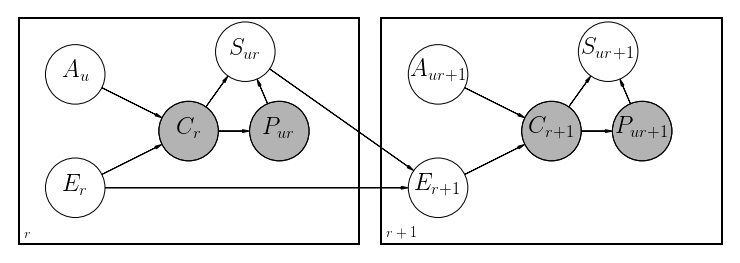

In [4]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)


pgm = daft.PGM(grid_unit=4.0, node_unit=1.4)

# Start with the plates.
rect_params = {"lw": 2}
edge_params = {
    'linewidth': 1
}
pgm.add_plate(
    [0, 0, 3, 2],
    label=r"\Large $r$",
    rect_params=rect_params,
)

pgm.add_plate(
    [3 + 0.2, 0, 3, 2],
    label=r"\Large $r+1$",
    rect_params=rect_params,
)

pgm.add_node("e_r", r"$E_r$", 0.5, 0.5, scale=1.5, fontsize=24)
pgm.add_node("e_r_1", r"$E_{r+1}$", 3.5 + 0.2, 0.5, scale=1.5, fontsize=24)
pgm.add_edge("e_r", "e_r_1", plot_params=edge_params)

pgm.add_node("c_r", r"$C_r$", 1.5, 1., scale=1.5, fontsize=24, observed=True)
pgm.add_node("c_r_1", r"$C_{r+1}$", 3.5 + 0.2 + 1, 1., scale=1.5, fontsize=24, observed=True)
pgm.add_edge("e_r", "c_r", plot_params=edge_params)
pgm.add_edge("e_r_1", "c_r_1", plot_params=edge_params)

pgm.add_node("a_r", r"$A_u$", 0.5, 1.5, scale=1.5, fontsize=24)
pgm.add_node("a_r_1", r"$A_{ur+1}$", 3.7, 1.5, scale=1.5, fontsize=24)
pgm.add_edge("a_r", "c_r", plot_params=edge_params)
pgm.add_edge("a_r_1", "c_r_1", plot_params=edge_params)

pgm.add_node("p_r", r"$P_{ur}$", 2.3, 1., scale=1.5, fontsize=24, observed=True)
pgm.add_node("p_r_1", r"$P_{ur+1}$", 3.5 + 2, 1., scale=1.5, fontsize=24, observed=True)
pgm.add_edge("c_r", "p_r", plot_params=edge_params)
pgm.add_edge("c_r_1", "p_r_1", plot_params=edge_params)

pgm.add_node("s_r", r"$S_{ur}$", 2., 1.7, scale=1.5, fontsize=24)
pgm.add_node("s_r_1", r"$S_{ur+1}$", 3.7 + 1.5, 1.7, scale=1.5, fontsize=24)
pgm.add_edge("c_r", "s_r", plot_params=edge_params)
pgm.add_edge("c_r_1", "s_r_1", plot_params=edge_params)

pgm.add_edge("p_r", "s_r", plot_params=edge_params)
pgm.add_edge("p_r_1", "s_r_1", plot_params=edge_params)
pgm.add_edge("s_r", "e_r_1", plot_params=edge_params)

# Render and save.
pgm.render()
pgm.savefig("dbn.png", dpi=150)

Here are the equations we'll be using for finding the parameters of the DBN.

\begin{align}
P\left(E_r=1\mid E{r-1}=0\right) & = 0 \label{eq:1} \tag{1} \\
P\left(A_u=1\right) & = \alpha_{uq} \label{eq:2} \tag{2} \\
P\left(C_r=1\mid E_r=1, A_u=1\right) & = 1 \label{eq:3} \tag{3} \\
P\left(S_{r}=1\mid C_r=0,P_r=0\right) & = 0 \label{eq:4} \tag{4} \\
P\left(S_{r}=1\mid C_r=1,P_r=0\right) & = \sigma_{uq} \label{eq:5} \tag{5} \\
P\left(S_{r}=1\mid C_r=1,P_r=1\right) & = 1 \label{eq:6} \tag{6} \\
P\left(E_{r}=1\mid S_{r-1}=1\right) & = 0 \label{eq:7} \tag{7} \\
P\left(E_{r}=1\mid E_{r-1}=1,S_{r-1}=0\right) & = \gamma \label{eq:8} \tag{8} \\
P\left(C_r=1\right) = P\left(C_{r}=1\mid E_r=1\right)\cdot P\left(E_r=1\right) & = \alpha_{uq}\epsilon_{ru}\label{eq:9} \tag{9} \\
\end{align}

Each query and each sku carries an attractive factor $\alpha_{uq}$. When the customer interacts  with a sku, there's a $\sigma_{uq}$ chance them'll enjoy it and end their browsing through the query result page. 

If they are not satisfied, they continue browsing through with a probability of $\gamma$.

In this model, only clicks and purchases are observed which means all other variables are hidden; in such case we use EM optimization techniques to find values for each parameter that best describes observed data in terms of log-likelihood.

This being said, the log-likelihood is given by:

$$\ell\ell = \sum_{s \in S}log\left(\sum_{\textbf{X}}P(\textbf{X}, \textbf{C}^{(s)}, \textbf{P}^{(s)} \mid \Psi \right)$$

Where $X$ represents the hidden variables, $C$ and $P$ are the observed data clicks and purhcases and finally $\Psi$ represents all variables used to model the data.

Finding the derivative of this equation is intractable thanks to the summation of the hidden variables. We use them the [Expectation-Maximization](https://towardsdatascience.com/inference-using-em-algorithm-d71cccb647bc) algorithm and aim to maximize the following $Q$ function:

$$Q = \sum_{s \in S} \mathbb{E}_{X|C^{(s)}}\left[logP\left(X, C^{(s)}, P^{(s)} \mid \Psi\right)\right]$$

In our case, as all variables are Bernoulli (either 0 or 1), each modeled by a parameter $\theta_c$ which translates the above to:

$$
Q(\theta_c) =\sum_{s \in S} \sum_{c_i \in s} \left(P\left(X_{c_i}^{(s)}=1, Par(X_{c_i}^{(s)}) = p \mid C^{(s)}, P^{(s)}, \Psi\right)log(\theta_c) + P\left(X_{c_i}^{(s)}=0, Par(X_{c_i}^{(s)}) = p \mid C^{(s)}, P^{(s)}, \Psi\right)log(1-\theta_c)\right) + Z 
$$

We'll be using this equation in the maximization step, derive it to find new optimum values for each parameter of our model and repeat the process until either we reach convergence (usually set by no increment in loglikelihood metric) or by total amount of desired iterations.

The derivative to find new values is given by:

$$\theta_c^{(t+1)} = \frac{\sum_{s\in S}\sum_{c_i \in s}P\left(P(X_{c_i}^{(s)}=1, Par(X_{c_i}^{(s)})=p \mid C^{(s)}, P^{(s)}, \Psi\right)}{\sum_{s\in S}\sum_{c_i \in s}P\left(Par(X_{c_i}^{(s)})=p \mid C^{(s)}, P^{(s)}, \Psi\right)}\label{eq:10} \tag{10}$$

## Attractiveness $\alpha_{uq}$

We have that:

$$P(A_u = 1) = \alpha_{uq}$$

Given equations 1-9, we can also derive that:

\begin{equation}
\begin{split}
\epsilon_1 & = P(E_1=1) = 1 \\
\epsilon_{r+1} & = P(E_{r+1} =1) \\
 & = P(E_{r+1} = 1 \mid E_r=1) \cdot P(E_r=1) \\
 & = \epsilon_r P\left(E_{r+1}=1 \mid S_r = 0, E_r=1\right) \cdot P(S_r=0 \mid E_r=1) \\
 & = \epsilon_r\gamma P(S_r=0 \mid E_r=1) \\
 & = \epsilon_r\gamma \left(P\left(S_r=0 \mid C_r = 0, P_r = 0, E_r=1 \right)P\left(C_r=0, P_r=0 \mid E_r=1\right) + P\left(S_r=0 \mid C_r = 0, P_r = 1, E_r=1 \right)P\left(C_r=0, P_r=1 \mid E_r=1\right) + P\left(S_r=0 \mid C_r = 1, P_r = 0, E_r=1 \right)P\left(C_r=1, P_r=0 \mid E_r=1\right) + P\left(S_r=0 \mid C_r = 1, P_r = 1, E_r=1 \right)P\left(C_r=1, P_r=1 \mid E_r=1\right)\right) \\
 & = \epsilon_r \gamma \left((1 - \alpha_{uq}) + (1 - \sigma_{uq})(1 - cr_{uq})\alpha_{uq} \right) 
\end{split}\label{eq:11} \tag{11}
\end{equation}

Where $cr$ is the conversion rate of document $u$ for query $q$.

Given equation 10, we derive for the attractiveness parameter the following updating rule:

$$\alpha_{uq}^{t+1} = \frac{\sum_{s \in S_{uq}} P(A_u = 1 \mid C, P)}{|S_{uq}|} \label{eq:12} \tag{12}$$

But given the structure of the DBN, we can infer that if $C$ is observed then $A_u$ is independent of $P$ as the former is a parent for the attractiveness variable. We can use this to assert a simplified updating rule:

$$\alpha_{uq}^{t+1} = \frac{\sum_{s \in S_{uq}} P(A_u = 1 \mid C)}{|S_{uq}|} \label{eq:13} \tag{13}$$

Which can be developed as follows:

$$
\begin{equation}
\begin{split}
 P(A_u = 1 \mid C) & =  P(A_u = 1 \mid C_r, C_{>r}) \\
  & = \unicode{x1D7D9}(C_r=1)\cdot P(A_u=1 \mid C_r = 1, C_{>r}) + \unicode{x1D7D9}(C_r=0)\cdot P(A_u=1 \mid C_r = 0, C_{>r}) \\
  & = c_r + (1 - c_r) \cdot \left(\unicode{x1D7D9}(C_{>r}=1) \cdot P(A_u=1|C_r=0, C_{>r}=1) + \unicode{x1D7D9}(C_{>r}=0) \cdot P(A_u=1 \mid C_r=0, C_{>r}=0)\right) \\
  & = c_r + (1 - c_r)(1 - c_{>r}) \cdot \frac{P(C_r=0, C_{>r}=0 \mid A_u=1) \cdot P(A_u=1)}{P(C_r=0, C_{>r} = 0)}
\end{split}\label{eq:14} \tag{14}
\end{equation}
 $$

Where $C_u$ is the click on current rank document and $C_{>r}$ is a random variable that is 1 if there's any click above current r and 0 otherwise.

Now developing the numerator of (14) we have:

$$
\begin{equation} 
\begin{split}
 P(C_r=0, C_{>r}=0 \mid A_u=1) & = P(C_r=0, C_{>r}=0 \mid A_u=1, E_r=0) \cdot P(E_r=0) \\
 & = P(E_r=0) = 1 - \epsilon_r
\end{split}\label{eq:14.1} \tag{14.1}
\end{equation}
 $$

The equation above is derived from the fact that an attractive document is only not clicked if it's not examined.

The numerator is already solved, we still need to develop the denominator:

$$
\begin{equation} 
\begin{split}
 P\left(C_r=0, C_{>r}=0\right) = P(C{\geq r}=0) = 1 - P(C_{\geq r} = 1)
\end{split}\label{eq:14.2} \tag{14.2}
\end{equation}
 $$

$$
\begin{equation} 
\begin{split}
P(C_{\geq r} = 1) = \epsilon_r \cdot X_r
\end{split}\label{eq:14.3} \tag{14.3}
\end{equation}
 $$

$$
\begin{equation} 
\begin{split}
X_r & = P(C_{\geq r} \mid E_r=1) \\
 & = P(C_r = 1 \mid E_r=1) + P(C_r=0, C_{\geq r+1} \mid E_r=1) \\
 & = \alpha_{uq} + P(C_{\geq r+1} \mid C_r=0, E_r=1) \cdot P(C_r=0|E_r=1) \\
 & = \alpha_{uq} + P(C_{\geq r+1} \mid E_{r+1}) \cdot P(E_{r+1}=1 \mid C_r=0, E_r=1) \cdot (1 - \alpha_{uq}) \\
 & = \alpha_{uq} + (1 - \alpha_{uq})\gamma X_{r+1}
\end{split}\label{eq:14.4} \tag{14.4}
\end{equation}
 $$

Finally, we have the updating rule for the attractiveness parameter:

$$ \alpha_{uq}^{(t+1)} = \frac{\sum_{s \in S_{uq}}\left(c_r^{(s)} + \left(1 - c_r^{(s)}\right)\left(1 - c_{>r}^{(s)}\right) \cdot \frac{\left(1 - \epsilon_r^{(t)}\right)\alpha_{uq}^{(t)}}{\left(1 - \epsilon_r^{(t)}X_r^{(t)} \right)} \right)}{|S_{uq}|} \label{eq:15} \tag{15}$$

Where $\epsilon_r$ is given by equation (11).

## Satisfaction $\sigma_{uq}$

In our presented DBN model, the satisfaction factor is only defined when:

$$ \sigma_{uq} = P(S_u=1 \mid C_r=1, P_r=0)$$

This means the updating rule for the satisfaction term is given by:

$$\sigma_{uq}^{(t+1)} = \frac{\sum_{s \in S'_{uq}}P(S_u=1 \mid C, P)}{|S'_{uq}|} \label{eq:16} \tag{16} $$

Which can be developed as:

$$
\begin{equation} 
\begin{split}
P(S_u=1 \mid C, P) &= P(S_u = 1 \mid C_r=1, P_r=0, C_{>r}=0, P_{>r}=0) \\
&= (1 - c_{>r})\cdot P(S_u=1 \mid C_r=1, P_r=0, C_{>r}=0, P_{>r}=0) \\
&= (1 - c_{>r})\cdot \frac{P(C_{>r}=0, P_{>r}=0 \mid S_u=1, C_r=1, P_r=0) \cdot P(S_u=1 \mid C_r=1, P_r=0)}{P(C_{>r}=0, P_{>r}=0 \mid C_r=1, P_r=0)} \\
&= \frac{(1 - c_r)(1-p_r)\sigma_{uq}}{P(P_{>r}=0 \mid C_{>r}=0, C_r=1, P_r=0) \cdot P(C_{>r}=0 \mid C_r=1, P_r=0)} \\
&= \frac{(1 - c_r)(1-p_r)\sigma_{uq}}{1 - P(C_{\geq r+1}=1 \mid E_{r+1})\cdot P(E_{r+1}\mid C_r=1, P_r=0)} \\
&= \frac{(1 - c_r)(1-p_r)\sigma_{uq}}{(1 - X_{r+1}\cdot (1-\alpha_{uq})\gamma)}
\end{split}\label{eq:17} \tag{17}
\end{equation}
 $$

Given equations (16) and (17), we devire that the updating rule is given by:

$$\sigma_{uq}^{(t+1)} = \frac{\sum_{s \in S^{[1, 0]}}\frac{(1 - c_r^{(t)})(1-p_r^{(t)})\sigma_{uq}^{(t)}}{(1 - X_{r+1}\cdot (1-\alpha_{uq}^{(t)})\gamma^{(t)})}}{|S^{[1, 0]}|} \label{eq:18} \tag{18}$$

Where $S^{[1, 0]}$ is the set of sessions of customers interactions where at rank $r$ there's an observed click and no purchase for document $u$ and query $q$.

## Persistence  $\gamma$

Persistence is defined as:

$$\gamma = P(E_{r+1} = 1 \mid E_r = 1, S_{ur}=0)$$

The sufficient statistics for this parameter is defined as:

$$ESS(z) = \sum_{s \in S} \sum_r P(E_{r+1}=z, E_r=1, S_{ur}=0 \mid C, P) \label{eq:19} \tag{19}$$

There's no closed form for this equation, so we use some techniques in order to able to compute it, like so:

$$
\begin{equation} 
\begin{split}
ESS(z) &= \sum_{s \in S}\sum_{r}\frac{P(E_{r+1}=\, E_r=1, S_u=0, C, P)}{P(C, P)} \\
&= \sum_{s \in S}\sum_{r}\frac{P(E_{r+1}=\, E_r=1, S_u=0, C, P)}{\sum_x \sum_y \sum_z P(E_{r+1}=z,E_r=x, S_u=y, C, P)} \\
&= \sum_{s \in S}\sum_{r}\frac{P(E_{r+1}=\, E_r=1, S_u=0, C, P) \cdot \frac{1}{P(C_{<r}, P_{<r})}}{\sum_x \sum_y \sum_z P(E_{r+1}=z,E_r=x, S_u=y, C, P)\cdot \frac{1}{P(C_{<r}, P_{<r})}} \\
&= \sum_{s \in S}\sum_{r}\frac{\phi^{(s)}(1, 0,z)}{\sum_x \sum_y \sum_z \phi^{(s)}(x, y, z)}
\end{split}\label{eq:19} \tag{19}
\end{equation}
 $$

The challege then becomes finding a description for the $\phi$ factor. We derive it as follows:

$$
\begin{equation} 
\begin{split}
\phi (x, y, z) &= P(E_r=x, C_r=c_r,P_r=p_r, S_u=y, E_{r+1}=z, C_{\geq {r+1}}, P_{\geq {r+1}} \mid C_{<r}, P_{<r}) \\
&= P(C{>r}, P{>r} \mid E_{r+1}=z, E_r=x, S_u=y, C_r=c_r, P_r=p_r) \cdot P(E_r=x, S_u=y, E_{r+1}=z, C_r=c_r, P_r=p_r \mid C_{<r}, P_{<r}) \\
&= P(C_{>r}, P_{>r} \mid E_{r+1}=z) \cdot P(E_{r+1}=z, S_u=y, C_r=c_r, P_r=p_r \mid E_r=x) \cdot P(E_r=x \mid C_{<r}, P_{<r})
\end{split}\label{eq:20} \tag{20}
\end{equation}
 $$

To solve this equation we'll devide it in three parts: first will be $$P(C_{>r}, P_{>r} \mid E_{r+1}=z)$$, second is $$P(E_{r+1}=z, S_u=y, C_r=c_r, P_r=p_r \mid E_r=x)$$ and finally $$P(E_r=x \mid C_{<r}, P_{<r})$$

Let's first solve $P(E_r=x \mid C_{<r}, P_{<r})$:

$$
\begin{equation} 
\begin{split}
P(E_{r+1}=1 \mid C_{<r+1}, P_{<r+1}) &= \epsilon_{r+1} = P(E_{r+1}=1 \mid E_r=1, C_{<r+1}, P_{<r+1})P(E_r=1 \mid C_{<r+1}, P_{<r+1}) \\
&=P(E_{r+1}=1 \mid E_r=1,C_r=1, P_r=0) \cdot P(E_r=1 \mid C_{<r+1}, P_{<r+1})c_r^{(s)}(1-p_r^{(s)}) + P(E_{r+1}=1 \mid E_r=1,C_r=0, P_r=0) \cdot P(E_r=1 \mid C_{<r+1}, P_{<r+1}) \cdot (1 - c_r^{(s)})(1-p_r^{(s)}) + P(E_{r+1}=1 \mid E_r=1,C_r=1, P_r=1) \cdot P(E_r=1 \mid C_{<r+1}, P_{<r+1})\cdot c_r^{(s)}p_r^{(s)}  \\
&= (1 - \sigma_{uq})\gamma c_r^{(s)}(1-p_r^{(s)}) + \gamma P(E_r=1 \mid C_r=0, P_r=0, C_{<r}, P_{<r})(1-c_r^{(s)})(1 -p_r^{(s)})
\end{split}\label{eq:21} \tag{21}
\end{equation}
 $$

To develop the inner probability equation, we have that:



$$
\begin{equation} 
\begin{split}
P(E_r=1 \mid C_r=0, P_r=0, C_{<r}, P_{<r}) &= \frac{P(E_r=1, C_r=0, P_r=0 \mid C_{<r}, P_{<r})}{P(C_r=0, P_r=0 \mid C_{<r}, P_{<r})} \\
&= \frac{P(C_r=0, P_r=0 \mid E_r=1, C_{<r}, P_{<r}) \cdot P(E_r=1\mid C_{<r}, P_{<r})}{P(C_r=0, P_r=0\mid C_{<r}, P_{<r})}
\end{split}\label{eq:22} \tag{22}
\end{equation}
 $$

Once again we need to develop the inner probability equation, which leads to:

$$
\begin{equation} 
\begin{split}
P(C_r=0, P_r=0 \mid C_{<r}, P_{<r}) &= P(P_r=0 \mid C_r=0) \cdot P(C_r=0 \mid C_{<r}, P_{<r}) \\
&= P(C_r=0 \mid C_{<r}, P_{<r}) = 1 - P(C_r=1 \mid C_{<r}, P_{<r})\\
&= 1- P(C_r=1 \mid E_r=1, C_{<r}, P_{<r}) \cdot P(E_r=1 \mid P_{<r}, C_{<r}) \\
&= 1 - \alpha_{uq}\epsilon_r
\end{split}\label{eq:23} \tag{23}
\end{equation}
 $$

Using 22 and 23 into 21 we finally get:

$$P(E_r =1\mid C_{<r}, P_{<r}) = (1 - \sigma_{uq}) \gamma c_r(1-p_r) + \frac{\gamma (1-\alpha_{uq})\epsilon_{r-1}}{(1 - \alpha_{uq} \epsilon_{r-1})}(1-c_r)(1-p_r) \label{eq:24} \tag{24}$$

Now we need to compute $P(C_{>r}, P_{>r} \mid E_{r+1}=z)$ which is derived as:

$$
\begin{equation} 
\begin{split}
P(C_{>r}, P_{>r} \mid E_{r+1}=z) &= P(C_r, P_r\mid C_{r-1}, P_{r-1}, ..., E_l=1) \cdot P(C_{r-1}, P_{r-1}, E_l=1) \\
 &= (1-\alpha \epsilon_{rl})\left((1-c_r)(1-p_r) + (1-w)(\alpha \epsilon_{rl}c_r(1-p_r)) + w \alpha \epsilon_{rl}c_r p_r \right) \cdot P(C_{r-1},P_{r-1} \mid C_{<r-1}, P_{<r-1}, E_l=1)
\end{split}\label{eq:25} \tag{25}
\end{equation}
 $$

Where $w$ is the conversion rate of given sku on a given query.

In [1]:
from IPython.core.display import HTML,display


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)


css_styling()